In [2]:
#######Life would have been simple with fastjet package, #######
#######but it cannot cluster pT, eta, phi objects yet :( #######
#import fastjet
#jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 0.4)
from pyjet import cluster,DTYPE_EP,DTYPE_PTEPM
import numba as nb
from itertools import chain
import scipy as sp

In [3]:
import sys
import IPython
#import ROOT
import awkward as ak
import vector
vector.register_awkward()
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
#import root_pandas as rpd
import uproot3
import uproot
import uproot4
import numpy as np
import math
#timers
import time
#if args.time:
#    start = time.clock()
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [4]:
#tree = uproot.open("root://polgrid4.in2p3.fr//dpm/in2p3.fr/home/cms/trivcat/store/user/usarkar/VBF_HToInvisible_M125_14TeV_powheg_pythia8_TuneCP5/crab_Multialgo_HGCAL/210930_084934/0000/ntuple_1.root",xrootdsource=dict(chunkbytes=1024**3, limitbytes=1024**3))["FloatingpointThresholdDummyHistomaxGenmatchGenclustersntuple/HGCalTriggerNtuple"]
#still opening with uproot3 for jet clustering, unable to parse the uproot4 df to pyjet...
tree2 = uproot3.open("/data_CMS/cms/sarkar/ntuple.root",xrootdsource=dict(chunkbytes=1024**3, limitbytes=1024**3))["FloatingpointThresholdDummyHistomaxGenmatchGenclustersntuple/HGCalTriggerNtuple"]
branches_cl3d = ["event","cl3d_pt","cl3d_energy","cl3d_eta","cl3d_phi"]
branches_gen = ["event","gen_eta","gen_phi","gen_pt","gen_pdgid","gen_energy","gen_status","genjet_eta","genjet_phi","genjet_pt","genjet_energy"]
full = ["gen_eta","gen_phi","gen_pt","gen_pdgid","gen_energy","gen_status","genjet_eta","genjet_phi","genjet_pt","genjet_energy","cl3d_pt","cl3d_energy","cl3d_eta","cl3d_phi"]

In [5]:
fulldf = tree2.pandas.df(full,flatten=False)
df = tree2.pandas.df(branches_cl3d,entrystart=0,entrystop=tree2.numentries)
fulldf["ak4jet_eta"] = fulldf["cl3d_eta"]
fulldf["ak4jet_phi"] = fulldf["cl3d_phi"]
fulldf["ak4jet_pt"] = fulldf["cl3d_pt"]
fulldf["ak4jet_constituents"] = fulldf["cl3d_energy"]

In [6]:
########computationally faster if lambda function is used here#########
for i_event in range(tree2.numentries):
    cl3d = df.loc[i_event,['cl3d_pt','cl3d_eta','cl3d_phi','cl3d_energy']]
    cl3d.columns=["pT","eta","phi","energy"]
    cl3d = cl3d.assign(mass=0)
    #go dataframe to np array, formatted for input into fastjet    
    cl3dVectors = np.array(cl3d[["pT","eta","phi","energy"]].to_records(index=False).astype([(u'pT', '<f8'), (u'eta', '<f8'), (u'phi', '<f8'), (u'mass', '<f8')]) )    
    clusterVals = cluster(cl3dVectors,R=0.4,algo="antikt")
    _jets = clusterVals.inclusive_jets() 
    ak4jet_eta = []
    ak4jet_phi = []
    ak4jet_pt = []
    ak4jetmatched_pt = []
    constituent = []
    for j,jet in enumerate(_jets):
        ak4jet_pt.append(jet.pt)
        ak4jet_eta.append(jet.eta)
        ak4jet_phi.append(jet.phi)
        constituent.append((len(_jets[j].constituents_array())))
        
    fulldf['ak4jet_eta'][i_event] = ak4jet_eta
    fulldf['ak4jet_phi'][i_event] = ak4jet_phi
    fulldf['ak4jet_pt'][i_event] = ak4jet_pt
    fulldf['ak4jet_constituents'][i_event] = constituent

In [7]:
#making an awkward array of ak4jet candidates
list_ak4jet_pt = fulldf["ak4jet_pt"].to_numpy()
list_ak4jet_eta = fulldf["ak4jet_eta"].to_numpy()
list_ak4jet_phi = fulldf["ak4jet_phi"].to_numpy()

ak4jet_pt = ak.Array(list_ak4jet_pt)
ak4jet_eta = ak.Array(list_ak4jet_eta)
ak4jet_phi = ak.Array(list_ak4jet_phi)
ak4jet = ak.zip({"pt":ak4jet_pt,"eta":ak4jet_eta,"phi":ak4jet_phi})
ak4jet = ak4jet[(abs(ak4jet.eta)>1.7) & (abs(ak4jet.eta)<2.8) & (ak4jet.pt>5)]

In [8]:
#opening the rest of the objects (gen_particles, gen_jets) using standard uproot4
tree = uproot.open("ntuple.root",xrootdsource=dict(chunkbytes=1024**3, limitbytes=1024**3))["FloatingpointThresholdDummyHistomaxGenmatchGenclustersntuple/HGCalTriggerNtuple"]

In [9]:
df_cl = tree.arrays(branches_cl3d,library='pd')   

In [10]:
######much easier but type conflict, needed to be fixed later#################
#df_gen = tree.arrays(["gen_pt", "gen_eta", "gen_phi","gen_energy","gen_pdgid","gen_status"], how="zip",library='ak', entry_stop=1)
#df_genjet = tree.arrays(["genjet_pt", "genjet_eta", "genjet_phi","genjet_energy"], how="zip",library='ak', entry_stop=1)

#print(df_gen.type)
#print(df_genjet.type)

In [11]:
gen_pt = tree["gen_pt"].array(library ="ak")
gen_eta = tree["gen_eta"].array(library ="ak")
gen_phi = tree["gen_phi"].array(library ="ak")
gen_energy = tree["gen_energy"].array(library ="ak")
gen_pdgid = tree["gen_pdgid"].array(library ="ak")
gen_status = tree["gen_status"].array(library ="ak")
genzip = ak.zip({"pt":gen_pt,"eta":gen_eta,"phi":gen_phi,"energy":gen_energy,"pdgid":gen_pdgid,"status":gen_status})
gen = genzip[(genzip.status==23) & (abs(genzip.pdgid<6)) & (genzip.pt>40) & (abs(genzip.eta)>1.7) & (abs(genzip.eta)<2.8)]

#gen = genzip
#print(gen)

In [12]:
genjet_pt = tree["genjet_pt"].array(library ="ak")
genjet_eta = tree["genjet_eta"].array(library ="ak")
genjet_phi = tree["genjet_phi"].array(library ="ak")
genjet_energy = tree["genjet_energy"].array(library ="ak")
genjetzip = ak.zip({"pt":genjet_pt,"eta":genjet_eta,"phi":genjet_phi,"energy":genjet_energy})
genjet = genjetzip
genjet = genjetzip[(abs(genjetzip.eta)>1.7) & (genjetzip.pt>10) & (abs(genjetzip.eta)<2.8)]
#print(genjet)

In [13]:
##making same types for deltaR calculation, followed from Jim Perversky tutorial

genjetmain = ak.with_name(genjet, "Momentum3D")
#print(genjet.type)

genmain = ak.with_name(gen, "Momentum4D")
#gen


gen_genjet = ak.cartesian({"gen": genmain, "genjet": genjetmain})
gen, genjet = ak.unzip(gen_genjet)

gen,genjet

(<MomentumArray4D [[], [], [], [], ... [], [], []] type='6120 * var * Momentum4D[...'>,
 <MomentumArray3D [[], [], [], [], ... [], [], []] type='6120 * var * Momentum3D[...'>)

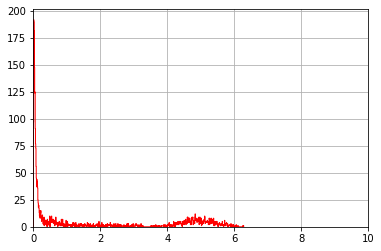

In [14]:
##DeltaR plot between parton-gen and genjet
dRmatched = ak.flatten(gen.deltaR(genjet), axis=None)
plt.hist(dRmatched,histtype='step', color='red',bins=800)
plt.grid(True)
plt.xlim([0, 10])
plt.show()

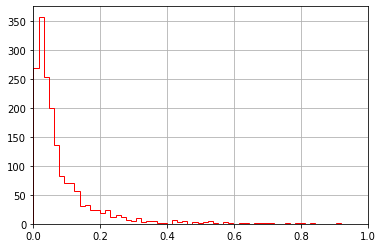

In [15]:
##minDeltaR plot between parton-gen and genjet
mindRgengenjet = ak.flatten(ak.min(gen.deltaR(genjet),axis = -1), axis = None)
plt.hist(mindRgengenjet,histtype='step', color='red',bins=400)
plt.grid(True)
plt.xlim([0., 1.])
plt.show()

In [17]:
##pT calculation based on the DeltaR requirement
genjetmatchedpt = ak.flatten(genjet.pt[(gen.deltaR(genjet)<0.2)], axis=None)
genpt = ak.flatten(gen.pt, axis=None)
genmatchedpt = ak.flatten(gen.pt[(gen.deltaR(genjet)<0.2)], axis=None)

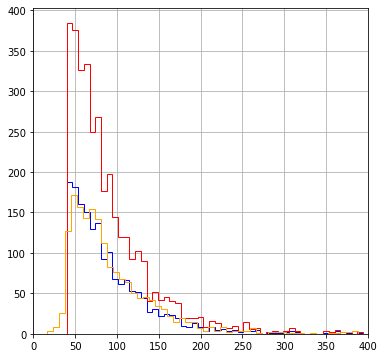

In [18]:
##Comparison of gen_pT, matched gen_pT and matched genjet_pT
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(genmatchedpt, color='blue',histtype='step',bins=80,label='reco-ak4jets')
ax.hist(genpt, color='r',histtype='step',bins=80,label='reco-ak4jets')
ax.hist(genjetmatchedpt, color='orange', histtype='step',bins=80,label='gen-matched genjets')
#ax.legend('reco-ak4jet')
ax.grid(True)
plt.xlim([0, 400])
#plt.yscale('log')
plt.show()

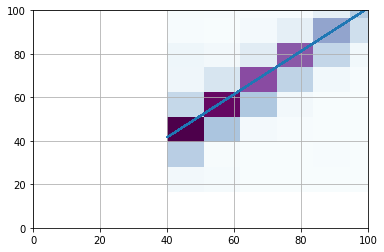

In [19]:
plt.hist2d(genmatchedpt,genjetmatchedpt, bins=(50, 50), cmap=plt.cm.BuPu)
m, b = np.polyfit(genmatchedpt, genjetmatchedpt, 1)
plt.plot(genmatchedpt, m*genmatchedpt + b)
plt.grid(True)
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.show()

1.0193132
0.21247627


(None, None)

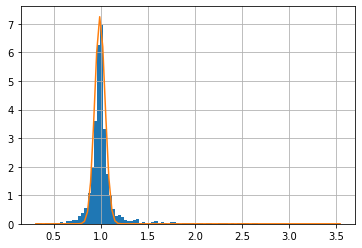

In [20]:
import scipy
from scipy import stats
data = genjetmatchedpt/genmatchedpt
_, bins, _ = plt.hist(data, 100, density=1, alpha=1.0)
mu, sigma = scipy.stats.norm.fit(data)

best_fit_line = scipy.stats.norm.pdf(bins, 0.99060524, 0.055)
plt.grid(True)
plt.plot(bins, best_fit_line)

print(mu), print(sigma)

In [22]:
##genjet candidate selection based on the DeltaR requirement
genjetmatchedzip = ak.Array(genjet[((gen.deltaR(genjet)<0.2) & ((genjet.pt/gen.pt)>0.8) & ((genjet.pt/gen.pt)<1.2))])
genmatchedzip = ak.Array(genjet[((gen.deltaR(genjet)<0.2) & ((genjet.pt/gen.pt)>0.8) & ((genjet.pt/gen.pt)<1.2))])
#print(genjetmatchedzip)

In [23]:
##Similar to before, this time between matched- genjet and ak4jet 
genmatchedmain = ak.with_name(genmatchedzip, "Momentum3D")
#print(genmatchedmain)

genjetmatchedmain = ak.with_name(genjetmatchedzip, "Momentum3D")
print(genjetmatchedmain)

ak4jets = ak.with_name(ak4jet, "Momentum3D")

genmatched_genjetmatched = ak.cartesian({"genjets": genmatchedmain, "genjetmatched": genjetmatchedmain})
genmatched, genjetmatched999 = ak.unzip(genmatched_genjetmatched)

reco_genjetmatched = ak.cartesian({"ak4jets": ak4jets, "genjetmatched": genjetmatchedmain})
ak4jet, genjetmatched = ak.unzip(reco_genjetmatched)
ak4jet, genjetmatched

[[], [], [], [], [], [], [], ... eta: -2.41, phi: 1.81, energy: 753}], [], [], []]


(<MomentumArray3D [[], [], [], [], ... [], [], []] type='6120 * var * Momentum3D[...'>,
 <MomentumArray3D [[], [], [], [], ... [], [], []] type='6120 * var * Momentum3D[...'>)

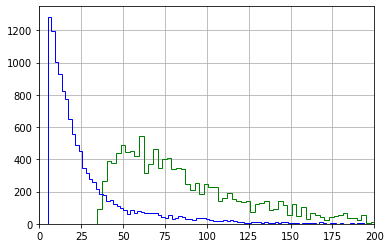

In [24]:
##pT comparison between matched genjet and ak4jets
ak4jetpt = ak.flatten(ak4jet.pt, axis=None)
genjetpt = ak.flatten(genjetmatched.pt, axis=None)
plt.hist(genjetpt,histtype='step', color='green',bins=200)
plt.hist(ak4jetpt,histtype='step', color='blue',bins=200)
plt.grid(True)
plt.xlim([0., 200.])
plt.show()

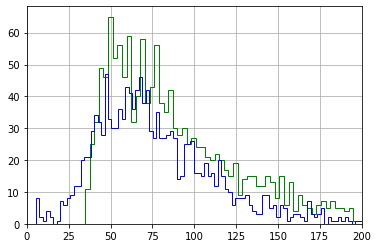

1.294215935635268
1.0412704899451324


(None, None)

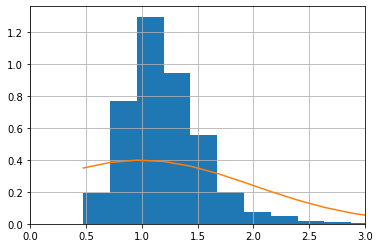

In [25]:
##pT comparison between matched genjet and ak4jets after DeltaR requirement 
genjetmatchedpt2 = ak.flatten(genjetmatched.pt[(ak4jet.deltaR(genjetmatched)<0.4)], axis=None)
ak4jetmatchedpt2 = ak.flatten(ak4jet.pt[(ak4jet.deltaR(genjetmatched)<0.4)], axis=None)

plt.hist(genjetmatchedpt2,histtype='step', color='green',bins=200)
plt.hist(ak4jetmatchedpt2,histtype='step', color='blue',bins=200)
plt.grid(True)
plt.xlim([0., 200.])
plt.show()
'''
ptdiffmin = ak.flatten(ak.min((genjetmatched.pt-ak4jet.pt), axis=-1), axis=None)
plt.hist(ptdiffmin,histtype='step', color='red',bins=100)
plt.grid(True)
plt.xlim([-200., 400.])
plt.show()
ptdiffmin2 = ak.to_numpy(ptdiffmin)
'''

data = genjetmatchedpt2/ak4jetmatchedpt2
_, bins, _ = plt.hist(data, 100, density=1, alpha=1.0)
mu, sigma = scipy.stats.norm.fit(data)

best_fit_line = scipy.stats.norm.pdf(bins, 0.99, 1.0)
plt.grid(True)
plt.xlim([0., 3.])
plt.plot(bins, best_fit_line)

print(mu), print(sigma)

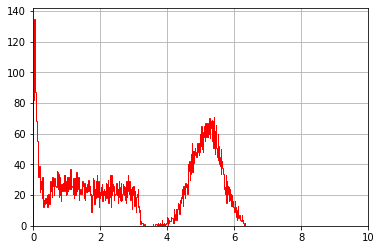

In [26]:
##DeltaR between matched genjet and ak4jets
deltaRjetmatched = ak.flatten((ak4jet.deltaR(genjetmatched)), axis=None)
plt.hist(deltaRjetmatched,histtype='step', color='red',bins=500)
plt.grid(True)
plt.xlim([0., 10.])
plt.show()

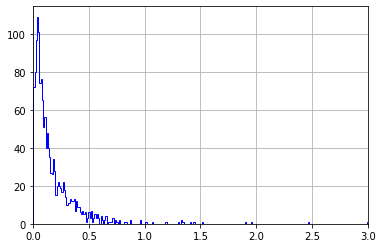

In [27]:
##minDeltaR between matched genjet and ak4jets
mindRgengenjet = ak.flatten(ak.min(ak4jet.deltaR(genjetmatched),axis = -1), axis = None)
plt.hist(mindRgengenjet,histtype='step', color='blue',bins=500)
plt.grid(True)
plt.xlim([0.,3.])
plt.show()

In [42]:
##ak4jet candidate selection based on the DeltaR requirement
ak4jetmatched = ak.Array(ak4jet[((ak4jet.deltaR(genjetmatched)<0.4) & (ak4jet.pt/genjetmatched.pt>0.8) & (ak4jet.pt/genjetmatched.pt<1.2))])
genjetmatchedfinal = ak.Array(genjetmatched[((ak4jet.deltaR(genjetmatched)<0.4) & (ak4jet.pt/genjetmatched.pt>0.8) & (ak4jet.pt/genjetmatched.pt<1.2))])

In [43]:
ak4matchedzippt = ak.flatten(ak4jetmatched.pt,axis=None)
genjetmatchedzip2pt = ak.flatten(genjetmatchedfinal.pt,axis=None)

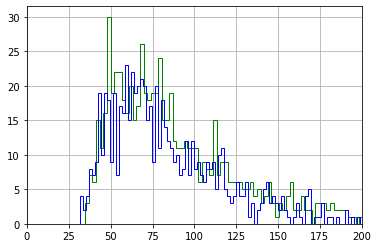

In [44]:
plt.hist(genjetmatchedzip2pt,histtype='step', color='green',bins=200)
plt.hist(ak4matchedzippt,histtype='step', color='blue',bins=200)
plt.grid(True)
plt.xlim([0., 200.])
plt.show()

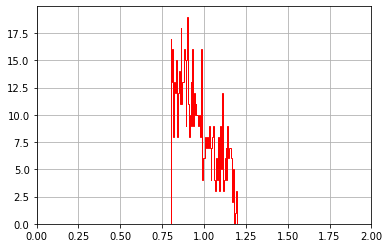

In [45]:
##pT ratio of matched genjet and matched ak4jet
l = ak4matchedzippt/genjetmatchedzip2pt
l = ak.flatten(l, axis=None)
plt.hist(l,histtype='step', color='red',bins=80)
plt.grid(True)
plt.xlim([0., 2.])
plt.show()

In [46]:
##Eta dependent pT correction based on regression, code adapted from Jona Motta
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

dfinal = ak.to_pandas(ak.Array({"ak4jetmatched_pt":ak4jetmatched.pt,"ak4jetmatched_eta":ak4jetmatched.eta,"genjetmatched_pt":genjetmatchedfinal.pt,"genjetmatched_eta":genjetmatchedfinal.eta}))
#dfinal

In [47]:
C1model_dict = {}       # dictionary of models from C1 calibration step
#input_c1 = fulldf.ak4jet_eta
ak4jetmatched_pt = ak.to_pandas(ak4jetmatched.pt)
genjetmatched_pt = ak.to_pandas(genjetmatchedfinal.pt)

ak4jetmatched_eta = ak.to_pandas(ak4jetmatched.eta)
input_c1 = ak4jetmatched_eta
target_c1 = ak4jetmatched_pt-genjetmatched_pt

C1model_dict = LinearRegression().fit(input_c1, target_c1)

#save_obj(C1model_dict, outFile_modelC1_dict)

dfinal['ak4jet_c1'] = C1model_dict.predict(input_c1)
dfinal['ak4jet_pt_c1'] = dfinal.ak4jet_c1 + dfinal.ak4jetmatched_pt
dfinal['ak4jet_response_c1'] = dfinal.ak4jet_pt_c1 / dfinal.genjetmatched_pt


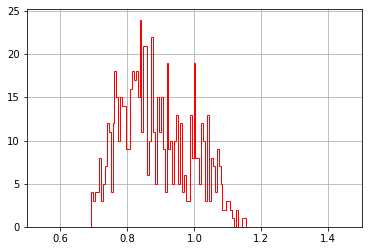

In [50]:
##Response plot after the regression
plt.hist(dfinal['ak4jet_response_c1'],histtype='step', color='red',bins=80)
plt.grid(True)
plt.xlim([0.5,1.5])
plt.show()